In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from sklearn.neighbors import KernelDensity
from scipy import stats

In [100]:
geo_df = pd.read_csv("/content/drive/MyDrive/ProjectGeodata/big_geo_omsk.csv", index_col="Unnamed: 0")
geo_df = geo_df.dropna()

In [101]:
#ancoring
top_y = 55.12
left_x = 72.99

bottom_y = 54.80
right_x = 73.67

y_side = 35600
x_side = 43400

In [102]:
geo_df = geo_df.drop(index = geo_df[geo_df["LATITUDE"] >= 55.11].index)
geo_df = geo_df.drop(index = geo_df[geo_df["LATITUDE"] <= 54.81].index)
geo_df = geo_df.drop(index = geo_df[geo_df["LONGITUDE"] <= 73].index)
geo_df = geo_df.drop(index = geo_df[geo_df["LONGITUDE"] >= 73.66].index)

In [103]:
geo_df["x_cord"] = (geo_df["LONGITUDE"] - left_x)/(right_x - left_x) * x_side
geo_df["y_cord"] = (geo_df["LATITUDE"] - bottom_y)/(top_y - bottom_y) * y_side

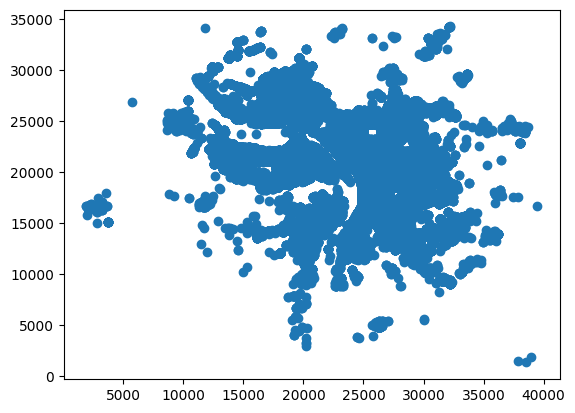

In [104]:
plt.scatter(geo_df["x_cord"], geo_df["y_cord"])

In [105]:
all_dates_of_geoset = geo_df["FORECAST_DATE"].unique()
points_array = np.array(((geo_df["x_cord"]),(geo_df["y_cord"]) ))

points_array = points_array.T

In [106]:
total_histogram = np.histogram2d(geo_df["x_cord"],geo_df["y_cord"], bins = (50,50))
total_histogram_vals = total_histogram[0]
total_histogram_bins = total_histogram[1]

total_histogram_vals = (total_histogram_vals/total_histogram_vals.sum()).T

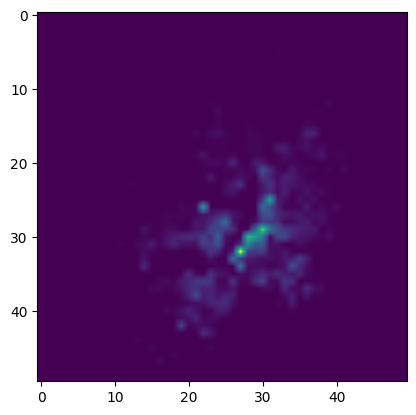

In [107]:
plt.imshow(total_histogram_vals, interpolation = "bilinear")

<Axes: >

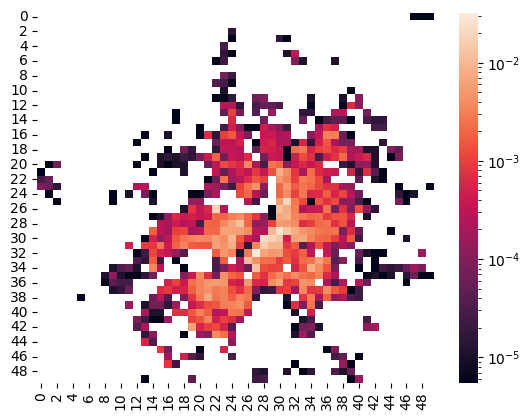

In [108]:
sns.heatmap(total_histogram_vals, norm = LogNorm())

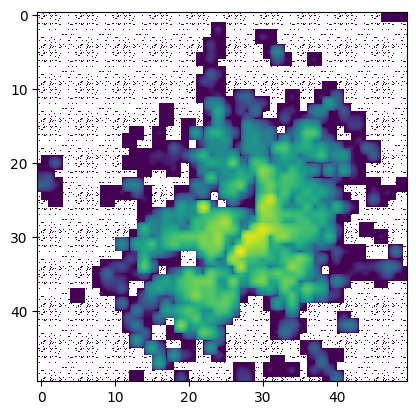

In [109]:
plt.imshow(total_histogram_vals, norm = LogNorm(), interpolation = "bilinear")

In [110]:
def heatmaps_over_day_generator(some_df):
  heatmap_tensor = []
  unique_days = list(some_df["FORECAST_DATE"].unique())
  unique_days.sort()
  tmp_histogram = np.histogram2d(geo_df[geo_df["FORECAST_DATE"] == unique_days[0]]["x_cord"],geo_df[geo_df["FORECAST_DATE"] == unique_days[0]]["y_cord"], bins = (50,50))
  tmp_histogram_vals = tmp_histogram[0]
  tmp_histogram_bins = tmp_histogram[1]
  heatmap_tensor.append(tmp_histogram_vals)
  for curr_day in unique_days:
    tmp_histogram = np.histogram2d(geo_df[geo_df["FORECAST_DATE"] == curr_day]["x_cord"],geo_df[geo_df["FORECAST_DATE"] == curr_day]["y_cord"], bins = tmp_histogram_bins)
    tmp_histogram_vals = tmp_histogram[0]
    tmp_histogram_bins = tmp_histogram[1]
    heatmap_tensor.append(tmp_histogram_vals)
  heatmap_tensor = np.array(heatmap_tensor[1::])
  return heatmap_tensor, unique_days



In [111]:
def heatmap_from_kde_generator(some_df):
  heatmap_tensor = []
  unique_days = list(some_df["FORECAST_DATE"].unique())
  unique_days.sort()
  kde_for_total = KernelDensity(kernel='gaussian', bandwidth=1).fit(total_scatter_data)

In [112]:
heatmap_tensor_over_days, corresponding_dates = heatmaps_over_day_generator(geo_df)

In [113]:
heatmap_tensor_over_days.shape

(600, 50, 50)

<Axes: >

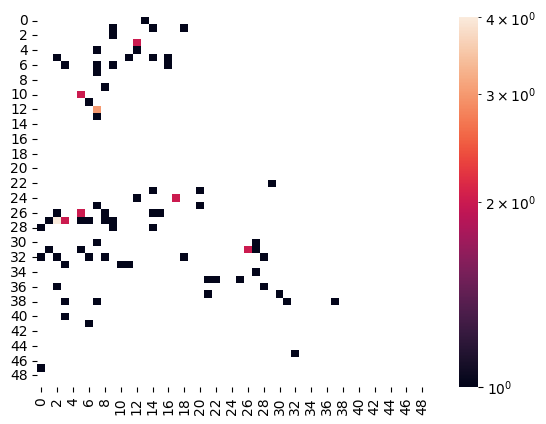

In [114]:
sns.heatmap(heatmap_tensor_over_days[521,:,:], norm = LogNorm())

In [115]:
def entropy_estimator(distribution_heatmap):
  prob_matrix = distribution_heatmap/distribution_heatmap.sum()
  entropy_matrix = np.zeros_like(prob_matrix)
  entropy_matrix[prob_matrix != 0] = prob_matrix[prob_matrix != 0]*np.log(prob_matrix[prob_matrix != 0])
  entropy = -entropy_matrix.sum()
  return entropy

In [116]:
sum_list = []
for i in range (heatmap_tensor_over_days.shape[0]):
  sum_list.append(heatmap_tensor_over_days[i,:,:].sum())

In [117]:
entropy_estimator(total_histogram_vals)

5.507587553224047

In [118]:
entropy_list = []
for i in range (heatmap_tensor_over_days.shape[0]):
  entropy_list.append(entropy_estimator(heatmap_tensor_over_days[i,:,:]))

<ipython-input-115-6026a8782893>:2: RuntimeWarning: invalid value encountered in divide
  prob_matrix = distribution_heatmap/distribution_heatmap.sum()


In [119]:
deliv_per_day = np.array(geo_df.groupby("FORECAST_DATE").count()["COMPLETED"])

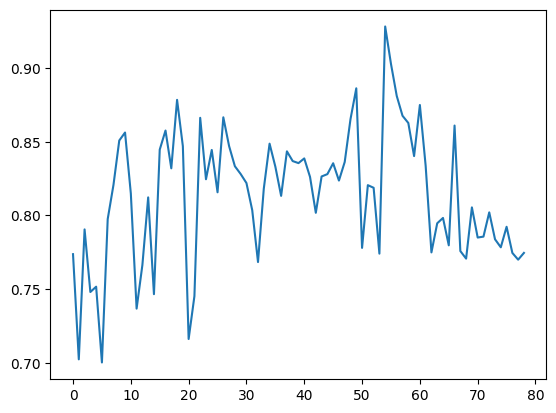

In [120]:
plt.plot(entropy_list[4+7*7::7]/np.log(deliv_per_day[4+7*7::7]))


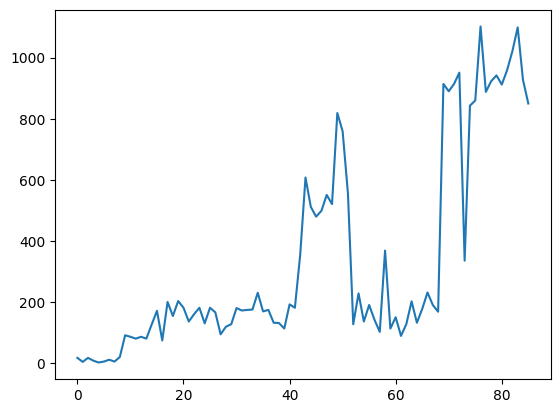

In [121]:
plt.plot(deliv_per_day[4::7])

In [122]:
time_series_df = geo_df.groupby(["FORECAST_DATE"]).count()

In [123]:
time_series_df = time_series_df[["x_cord", "y_cord"]]

In [124]:
time_series_df["num_of_orders"] = time_series_df["y_cord"]
time_series_df["entropy"] = entropy_list

In [125]:
time_series_df = time_series_df[["num_of_orders", "entropy"]]

In [126]:
time_series_df.to_csv("time_series_data.csv")

In [127]:
geo_df.to_csv("refinded_geo_dataset.csv")

In [128]:
cour_data = pd.read_csv('/content/cour_per_day.csv', sep = ';')

In [129]:
cour_data

,дата,Кол-во КК
0,2023-05-05 07:00:00.000 +0700,21
1,2023-05-06 07:00:00.000 +0700,10
2,2023-05-07 07:00:00.000 +0700,10
3,2023-05-08 07:00:00.000 +0700,16
4,2023-05-10 07:00:00.000 +0700,25
...,...,...
119,2023-09-02 07:00:00.000 +0700,9
120,2023-09-03 07:00:00.000 +0700,10
121,2023-09-04 07:00:00.000 +0700,22
122,2023-09-05 07:00:00.000 +0700,19


In [130]:
time_series_df = pd.read_csv("/content/time_series_data.csv")

In [131]:
time_series_df

,FORECAST_DATE,num_of_orders,entropy
0,2022-01-04,22,2.201512
1,2022-01-05,4,1.386294
2,2022-01-06,17,2.197225
3,2022-01-08,14,1.973001
4,2022-01-09,18,2.145842
...,...,...,...
595,2023-08-31,567,4.985495
596,2023-09-01,612,5.233561
597,2023-09-02,198,4.318521
598,2023-09-03,193,4.373321


In [132]:
cour_data["дата"] = cour_data["дата"].str[:10]

In [133]:
time_series_df = time_series_df.reset_index()

In [134]:
time_series_df

,index,FORECAST_DATE,num_of_orders,entropy
0,0,2022-01-04,22,2.201512
1,1,2022-01-05,4,1.386294
2,2,2022-01-06,17,2.197225
3,3,2022-01-08,14,1.973001
4,4,2022-01-09,18,2.145842
...,...,...,...,...
595,595,2023-08-31,567,4.985495
596,596,2023-09-01,612,5.233561
597,597,2023-09-02,198,4.318521
598,598,2023-09-03,193,4.373321


In [135]:
dates_list = list(cour_data["дата"])

In [136]:
sub_df = time_series_df.query(' FORECAST_DATE in @dates_list ')

In [137]:
sub_df = sub_df.drop(["index"], axis = 1)

In [138]:
cour_data = cour_data.rename(columns = {'дата' : 'FORECAST_DATE', 'Кол-во КК' : 'cour_num'})

In [139]:
cour_data = cour_data.drop([122,123])

In [155]:
cour_data

,FORECAST_DATE,cour_num
0,2023-05-05,21
1,2023-05-06,10
2,2023-05-07,10
3,2023-05-08,16
4,2023-05-10,25
...,...,...
117,2023-08-31,19
118,2023-09-01,20
119,2023-09-02,9
120,2023-09-03,10


In [142]:
list(sub_df["FORECAST_DATE"]) == list(cour_data["FORECAST_DATE"])

True

In [161]:
cour_data["cour_num"]

0      21
1      10
2      10
3      16
4      25
       ..
117    19
118    20
119     9
120    10
121    22
Name: cour_num, Length: 122, dtype: int64

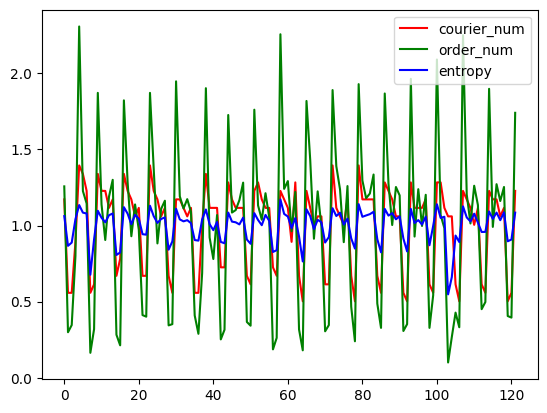

In [50]:
plt.plot(cour_data["cour_num"][:-2]/cour_data["cour_num"][:-2].mean(), color = 'red', label = "courier_num")
plt.plot(np.arange(len(sub_df)), sub_df["num_of_orders"]/sub_df["num_of_orders"].mean(), color = 'green', label = "order_num")
plt.plot(np.arange(len(sub_df)), sub_df["entropy"]/sub_df["entropy"].mean(), color = 'blue', label = "entropy")
plt.legend(loc = 'upper right')

In [168]:
sub_df = sub_df.reset_index().drop(["index"], axis = 1)

In [169]:
sub_df["courier_num"] = cour_data["cour_num"]

In [171]:
sub_df.to_csv("dataset_for_predictions.csv")